# EMBER Characterizations Notebook

This notebook contains all the methods for visualizing EMBER measurement data.

## Import libraries

External libraries: `matplotlib`, `numpy`, `scipy`, `pandas`.

In [33]:
# Import internal libraries
import json

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd

## Pick VDDIO (VDDLS) to study

Most experiments operate at some particular VDDLS value. Set that here.

In [28]:
# Set VDDIO (times 10)
vddio = 25

## RRAM FORM statistics

Here, we plot the distribution of WL DAC levels needed to induce FORMing (at VDDLS=3.3V). Then we plot the distribution of the resultant final conductance values after FORMing.

In [ ]:
# Load log file
names = ["chip", "time", "addr", "operation", "mask", "wl_dac_lvl", "bsl_dac_lvl", "sa_do", "ignore"]
formdata = pd.read_csv("../data/form.5mhz.188cell.csv", names=names, index_col=False)
formdata.sa_do = formdata.sa_do.shift(-1, fill_value=0)
formdata["nform"] = formdata.sa_do.apply(lambda di: bin(di).count("1"))
formdata = formdata[formdata.operation == "SET"]

# Figure for FORM-inducing WL DAC level statistics
plt.figure(figsize=(5,3))
formdata[formdata.operation == "SET"].groupby("wl_dac_lvl").sum()["nform"].plot.bar(width=1)
plt.title("FORM-Inducing WL DAC Statistics (188x48 cells)")
plt.xlabel("WL DAC Level")
plt.ylabel("Frequency")
plt.text(100, 100, "bl_dac_lvl=31\nclk=5MHz\npw=3us\nread_dac_lvl=7\nclamp_ref_lvl=1\nform_thresh=32")
plt.locator_params(nbins=10)
plt.tight_layout()
plt.savefig("figs/form.wl.stats.pdf")

In [ ]:
# Load log file
names = ["addr", "time"] + ["read_" + str(i) for i in range(48)]
formreaddata = pd.read_csv("../data/formread.5mhz.188cell.csv", names=names, index_col=False, delimiter="\t")

# Figure for post-FORM READ statistics
plt.figure(figsize=(5,3))
plt.bar(np.arange(2, 64, 4), np.bincount(formreaddata[formreaddata.columns[-48:]].values.flatten()), width=4)
plt.title("Post-FORM READ Statistics (188x48 cells)")
plt.xlabel("READ Ref Level")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figs/form.read.stats.pdf")

## Checkerboard demo

Here, we plot programmed checkerboard patterns to demonstrate 1-4bpc programmability. We also indicate the Gray code BER and linear root mean squared error (RMSE) of the measured values from the programmed values.

[[1152    0]
 [   0 1152]]
[[576   0   0   0]
 [  0 576   0   0]
 [  0   0 576   0]
 [  0   0   0 576]]
[[288   0   0   0   0   0   0   0]
 [  1 284   3   0   0   0   0   0]
 [  0   1 287   0   0   0   0   0]
 [  0   0   1 286   1   0   0   0]
 [  0   0   0   0 288   0   0   0]
 [  0   0   0   0   0 288   0   0]
 [  0   0   0   0   0   0 288   0]
 [  0   0   0   0   0   0   0 288]]
[[143   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 17 102  25   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3  11 118  12   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1  21 101  20   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0   3  13 117  11   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   6 122  16   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   7 124  13   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   5 121  18   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   6 116  22   0   0   0   0   0   0]
 [  0   0   

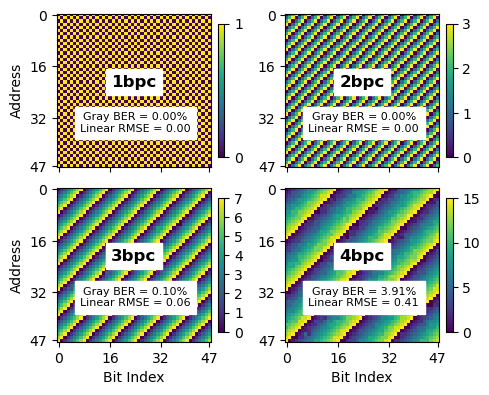

In [48]:
# Produce checkerboard plots for 1-4 bpc
confmats = []
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(5,4))
for bpc in range(1, 5):
  # Subplot
  plt.subplot(220 + bpc)

  # Load data
  names = ["addr", "time"] + ["read_" + str(i) for i in range(48)]
  data = pd.read_csv(f"../data/{bpc}bpc.csv", sep="\t", names=names)

  # Show multi-bit result
  matdata = data[data.columns[-48:]].values[:48]
  im = plt.imshow(matdata, vmin=0, vmax=2**bpc-1)
  cbar = plt.colorbar(im, fraction=0.04, pad=0.04)
  if bpc != 4:
    cbar.set_ticks(range(2**bpc))
  # cbar.set_label("READ Value")
  plt.title(f"{bpc}bpc", x=0.5, y=0.5, verticalalignment="center", horizontalalignment="center", backgroundcolor="white", fontweight="bold")
  if bpc > 2:
    plt.xlabel("Bit Index")
  if bpc % 2 == 1:
    plt.ylabel("Address")

  # Load data into confmat
  confmat = np.zeros(shape=(2**bpc, 2**bpc))
  for i in range(48):
    for j in range(48):
      confmat[(data["addr"][i] + j) % (2**bpc)][matdata[i][j]] += 1
  confmat = confmat.astype(int)
  print(confmat)

  # Symbol error magnitudes
  mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
  rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

  # Function to get Gray code string
  getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

  # Function to get Gray code error rate for each possible symbol confusion
  grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc
  # print(grayerr)

  # BER
  ber = (grayerr * confmat).sum() / confmat.sum()
  plt.text(0.5*48, 0.7*48, f"Gray BER = " + format(ber*100, ".2f") + "%\nLinear RMSE = " + format(rmse, ".2f"), fontsize=8, verticalalignment="center", horizontalalignment="center", backgroundcolor="white")

  # Set ticks
  plt.xticks([0,16,32,47])
  plt.yticks([0,16,32,47])
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.5)
plt.tight_layout()
plt.savefig("figs/cb.pdf")
plt.show()

def binary_to_gray_op(n):
  n = int(n, 2)
  n ^= (n >> 1)
  return bin(n)[2:]

## Conductance level visualization

Here, we plot the READ/WRITE level boundaries.

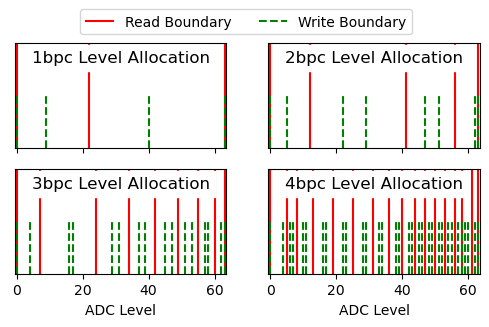

In [70]:
# Plot conductance ranges
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(6,3))
for bpc in range(1, 5):
    # Subplot
    plt.subplot(220 + bpc)
    
    # Load settings
    settings = json.load(open(f"../settings/{bpc}bpc.json"))
    
    # Plot
    plt.axvline(0, 0, 1, color='r', label="Read Boundary" if bpc == 1 else None)
    for level in settings["level_settings"]:
        plt.axvline(level["adc_upper_read_ref_lvl"], 0, 1, color='r')
        plt.axvline(level["adc_lower_write_ref_lvl"], 0, 0.5, color='g', linestyle='--')
        plt.axvline(level["adc_upper_write_ref_lvl"], 0, 0.5, color='g', linestyle='--', label="Write Boundary" if bpc == 1 and level["adc_upper_write_ref_lvl"] == 63 else None)
    plt.xlim(-0.5, 63.5)
    plt.gca().get_yaxis().set_visible(False)
    plt.title(f"{bpc}bpc Level Allocation", backgroundcolor="white", y=1, pad=-14)
    if bpc > 2:
        plt.xlabel("ADC Level")
fig.legend(loc="center", bbox_to_anchor=(0.51, 0.95), ncol=2)
plt.savefig("figs/levels.pdf")
plt.show()

## Endurance

Here, we show so endurance cycling data caused by SET/RESET loops (without verify), with READs performed intermittently.

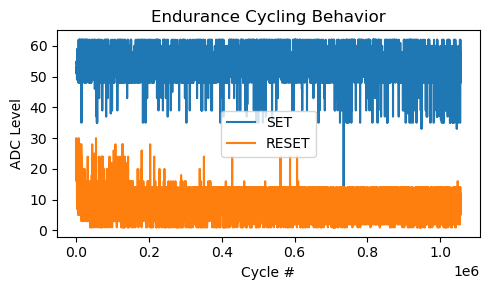

In [71]:
# Load endurance and show an example
names = ["addr", "i", "Cycle #", "RESET", "SET"]
data = pd.read_csv(f"../data/endurance.csv.gz", delimiter='\t', names=names)
data = data[data["addr"] == 10900]
data = data[data["i"] == 9]
plt.rcParams["figure.figsize"] = (5,3)
data.groupby("i").plot("Cycle #", ["SET", "RESET"], title="Endurance Cycling Behavior", ylabel="ADC Level")
plt.tight_layout()
plt.savefig("figs/endurance.pdf")
plt.show()

## Retention data
Here, we show the sigma vs. mu for conductance level allocation, and also plot the conductance distributions of each programmed level at time `t`. 

In [72]:
# Load retention time data
tdata = pd.read_csv("../data/retention2.min.csv.gz")
tdata

,Unnamed: 0,addr,time,lvl,lvli,i,tmin,tmax,timept
0,0,1024,0.000000,6,6,0,4,8,0.0
1,1,1024,0.000000,8,6,1,4,8,0.0
2,2,1024,0.000000,7,6,2,4,8,0.0
3,3,1024,0.000000,5,6,3,4,8,0.0
4,4,1024,0.000000,6,6,4,4,8,0.0
...,...,...,...,...,...,...,...,...,...
113627,62790555,1977,80014.943718,56,58,11,57,61,100000.0
113628,62790556,1977,80014.943718,59,58,12,57,61,100000.0
113629,62790557,1977,80014.943718,58,58,13,57,61,100000.0
113630,62790558,1977,80014.943718,59,58,14,57,61,100000.0


In [ ]:
# Plot sigma-mu
%matplotlib inline
times = [0, 0.1, 1, 10, 100, 1000, 10000, 100000]
for time in times:
    sbadata = tdata[(tdata["timept"] == time) & tdata["lvli"].isin(range(0,64,1))].groupby("lvli")["lvl"].std()
    sbadata.plot(label=f"data,t={time}")
    fit = np.polyfit(sbadata.index.values, sbadata.values, 3)
    print(np.poly1d(fit))
    plt.plot(range(4,64), np.poly1d(fit)(range(4,64)), '--', label=f"fit,t={time}")
plt.title("Sigma-Mu Plot for SBA")
plt.xlabel("Programmed Level")
plt.ylabel("Stdev. of READ Level")
# plt.legend()
plt.tight_layout()
plt.savefig("figs/sigmamu.pdf")
plt.show()

In [ ]:
# Plot frequency of each level to check
plt.rcParams["figure.figsize"] = [9, 4]
tdata.groupby("lvli").count()["lvl"].plot.bar()
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
# Show distribution
time = 100
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (1024 cells w/64 levels, ~3hrs)")
d = tdata[(tdata["timept"] == time) & tdata["lvli"].isin(range(0,64,1))]
for i in range(64):
    rdata = d[d["lvli"] == i]
    if len(rdata) != 0:
        plt.plot(sorted(rdata["lvl"].values), np.linspace(0+1/len(rdata), 1-1/len(rdata), len(rdata)), label=i)
plt.xlabel("Programmed Level")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 64)
plt.ylim(0.001, 0.999)
plt.tight_layout()
plt.show()

## SET/RESET final conductance sweeps

We test the effect of pulses with different {VWL, VBL, pw, gi} combos on final conductance gf.

### SET sweep

In [11]:
# SET sweep data
setdata = pd.read_csv(f"../data/setsweep{vddio}.csv", delimiter="\t", names=["addr", "t", "vwl", "vbl", "pw"] + [f"gi[{i}]" for i in range(16)] + [f"gf[{i}]" for i in range(16)])
setdata = pd.concat([setdata[["addr","t","vwl","vbl","pw",f"gi[{i}]",f"gf[{i}]"]].rename(columns={f"gi[{i}]" : "gi", f"gf[{i}]" : "gf"}) for i in range(16)])
setdata

,addr,t,vwl,vbl,pw,gi,gf
0,58881,1.685559e+09,0,0,1,6,6
1,58292,1.685559e+09,0,4,1,9,9
2,30216,1.685559e+09,0,8,1,4,4
3,44022,1.685559e+09,0,12,1,5,4
4,43578,1.685559e+09,0,16,1,5,31
...,...,...,...,...,...,...,...
136825,22753,1.685598e+09,226,8,16,35,37
136826,50171,1.685598e+09,226,12,16,30,38
136827,21265,1.685598e+09,226,16,16,5,42
136828,6292,1.685598e+09,226,20,16,7,49


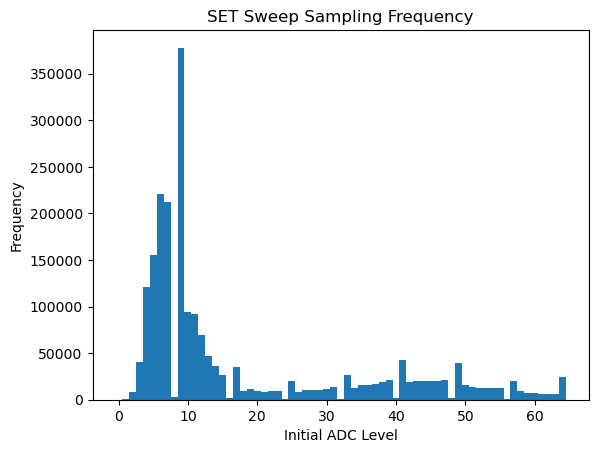

In [12]:
# SET sweep gi sampling frequency check
setdata["gi"].plot.hist(bins=np.arange(-0.5, 65.5))
plt.title("SET Sweep $g_i$ Sampling Frequency")
plt.xlabel("Initial ADC Level")
plt.show()

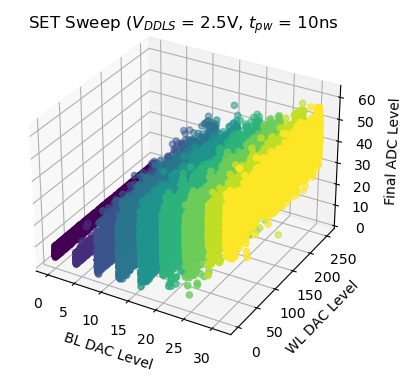

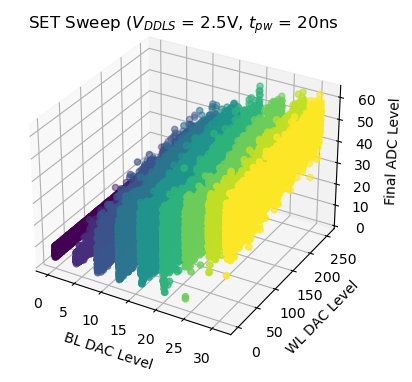

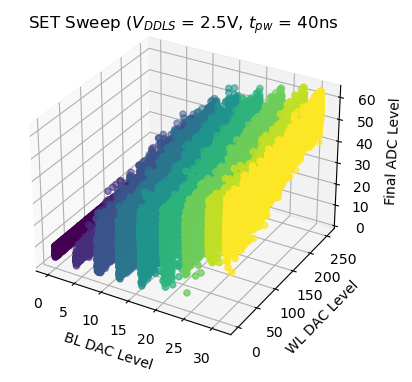

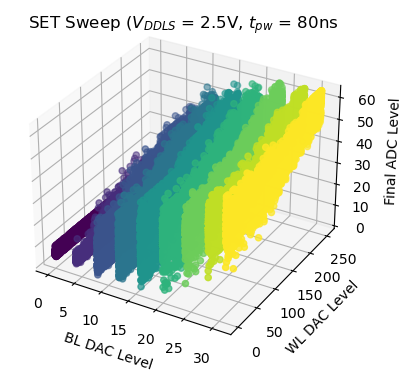

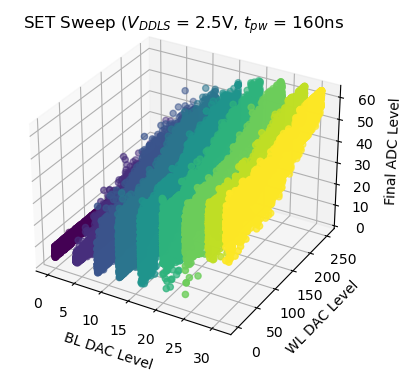

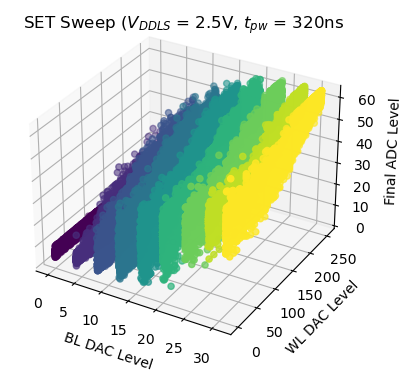

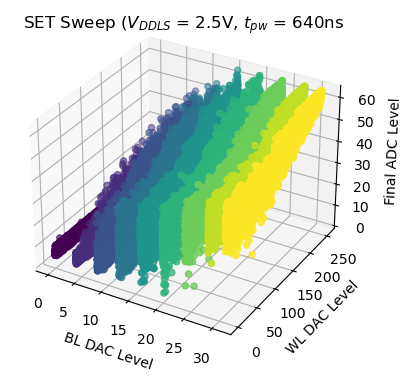

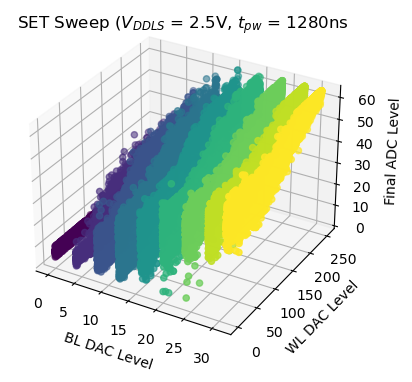

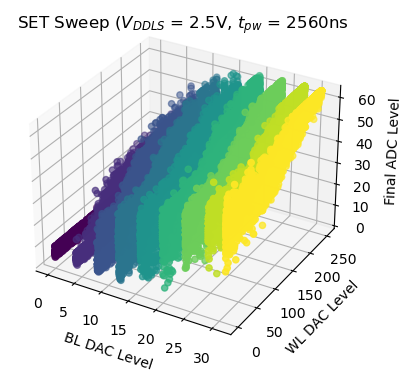

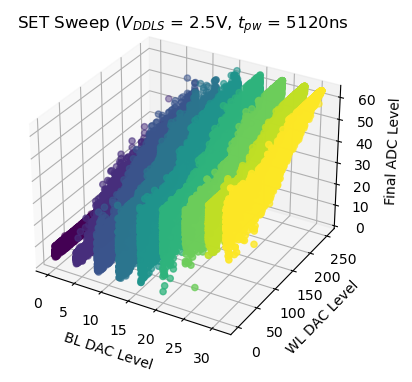

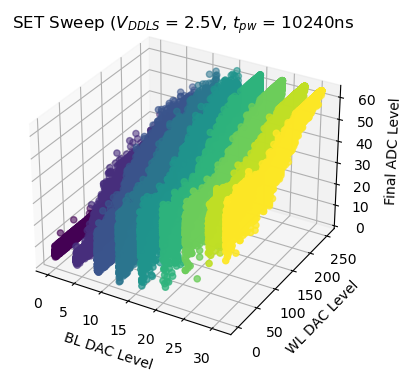

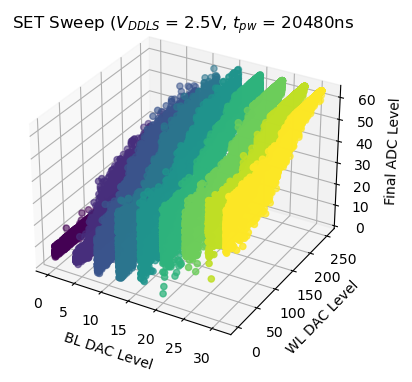

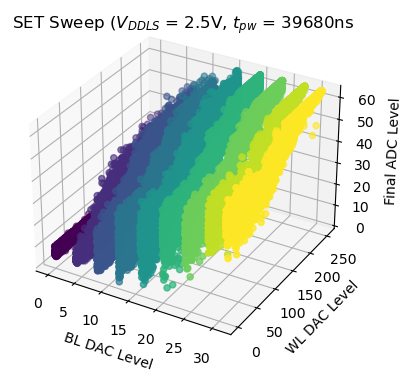

In [13]:
# Plot SET sweep
for pw in setdata["pw"].unique():
    d = setdata[(setdata["gi"].isin(range(5,9))) & (setdata["pw"] == pw)][["vwl","vbl","pw","gf"]]
    fig = plt.figure(figsize=(5.5, 4.5))
    ax = plt.axes(projection='3d')
    ax.set_title(f"SET Sweep ($V_{{DDLS}}$ = {vddio/10}V, $t_{{pw}}$ = {pw*10}ns", y=1)
    ax.set_xlabel("BL DAC Level")
    ax.set_ylabel("WL DAC Level")
    ax.set_zlabel("Final ADC Level")
    ax.set_zlim(0, 64)
#     ax.view_init(elev=7, azim=-26)
    ax.scatter3D(d['vbl'], d['vwl'], d['gf'], c=d['vbl'])
    plt.savefig(f"figs/set_sweep_{vddio}_{str(pw).zfill(4)}.png", dpi=300)
    
#     setdatamean = setdata[(setdata["gi"].isin(range(5,9))) & (setdata["pw"] == pw)].groupby(["vwl","vbl","pw"])["gf"].mean().reset_index()
#     d = setdatamean[setdatamean["pw"] == pw]
#     fig = plt.figure(figsize=(10, 10))
#     ax = plt.axes(projection='3d')
#     ax.set_title(f"SET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
#     ax.set_xlabel("BL DAC Level")
#     ax.set_ylabel("WL DAC Level")
#     ax.set_zlabel("Mean Final ADC Level")
#     ax.set_zlim(0, 64)
#     ax.view_init(elev=7, azim=-26)
#     ax.plot_trisurf(d['vbl'], d['vwl'], d['gf'], label=f"pw={pw}")
#     plt.savefig(f"figs/set_sweep_{vddio}_mean_{str(pw).zfill(4)}.png", dpi=300)

#     setdatastd = setdata[(setdata["gi"].isin(range(5,9))) & (setdata["pw"] == pw)].groupby(["vwl","vbl","pw"])["gf"].std().reset_index()
#     d = setdatastd[setdatastd["pw"] == pw]
#     fig = plt.figure(figsize=(10, 10))
#     ax = plt.axes(projection='3d')
#     ax.set_title(f"SET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
#     ax.set_xlabel("BL DAC Level")
#     ax.set_ylabel("WL DAC Level")
#     ax.set_zlabel("Stdev. Final ADC Level")
#     ax.set_zlim(0, 8)
#     ax.view_init(elev=7, azim=-26)
#     ax.plot_trisurf(d['vbl'], d['vwl'], d['gf'], label=f"pw={pw}")
#     plt.savefig(f"figs/set_sweep_{vddio}_std_{str(pw).zfill(4)}.png", dpi=300)

### RESET sweep

In [ ]:
# RESET sweep data
resetdata = pd.read_csv(f"../data/resetsweep{vddio}.csv", delimiter="\t", names=["addr", "t", "vwl", "vsl", "pw"] + [f"gi[{i}]" for i in range(16)] + [f"gf[{i}]" for i in range(16)])
resetdata = pd.concat([resetdata[["addr","t","vwl","vsl","pw",f"gi[{i}]",f"gf[{i}]"]].rename(columns={f"gi[{i}]" : "gi", f"gf[{i}]" : "gf"}) for i in range(16)])
resetdata

In [ ]:
# RESET sweep gi sampling frequency check
plt.figure()
resetdata["gi"].plot.hist(bins=np.arange(-0.5, 65.5))
plt.title("RESET Sweep $g_i$ Sampling Frequency")
plt.xlabel("Initial ADC Level")
plt.show()

In [ ]:
# Plot RESET sweep
for pw in resetdata["pw"].unique():
    d = resetdata[(resetdata["gi"].isin(range(55,59))) & (resetdata["pw"] == pw)][["vwl","vsl","pw","gf"]]
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_title(f"RESET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
    ax.set_xlabel("SL DAC Level")
    ax.set_ylabel("WL DAC Level")
    ax.set_zlabel("Final ADC Level")
    ax.set_zlim(0, 64)
    ax.view_init(elev=21, azim=42)
    ax.scatter3D(d['vsl'], d['vwl'], d['gf'], c=d['vsl'])
    plt.savefig(f"figs/reset_sweep_{vddio}_{str(pw).zfill(4)}.png", dpi=300)

#     resetdatamean = resetdata[(resetdata["gi"].isin(range(55,59))) & (resetdata["pw"] == pw)].groupby(["vwl","vsl","pw"])["gf"].mean().reset_index()
#     d = resetdatamean[resetdatamean["pw"] == pw]
#     fig = plt.figure(figsize=(10, 10))
#     ax = plt.axes(projection='3d')
#     ax.set_title(f"RESET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
#     ax.set_xlabel("SL DAC Level")
#     ax.set_ylabel("WL DAC Level")
#     ax.set_zlabel("Mean Final ADC Level")
#     ax.set_zlim(0, 64)
#     ax.view_init(elev=21, azim=42)
#     ax.plot_trisurf(d['vsl'], d['vwl'], d['gf'], label=f"pw={pw}")
#     plt.savefig(f"figs/reset_sweep_{vddio}_mean_{str(pw).zfill(4)}.png", dpi=300)
    
#     resetdatastd = resetdata[(resetdata["gi"].isin(range(55,59))) & (resetdata["pw"] == pw)].groupby(["vwl","vsl","pw"])["gf"].std().reset_index()
#     d = resetdatastd[resetdatastd["pw"] == pw]
#     fig = plt.figure(figsize=(10, 10))
#     ax = plt.axes(projection='3d')
#     ax.set_title(f"RESET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
#     ax.set_xlabel("SL DAC Level")
#     ax.set_ylabel("WL DAC Level")
#     ax.set_zlabel("Stdev. Final ADC Level")
#     ax.set_zlim(0, 12)
#     ax.view_init(elev=21, azim=42)
#     ax.plot_trisurf(d['vsl'], d['vwl'], d['gf'], label=f"pw={pw}")
#     plt.savefig(f"figs/reset_sweep_{vddio}_std_{str(pw).zfill(4)}.png", dpi=300)

## SET/RESET Energy
In this section, we measure SET/RESET energy across different pulse conditions.

### SET Pulse Energy

In [21]:
# Load data and convert voltage/current to power
edatas = []
for i in range(3):
    vs = ["vdd", "vdd_dac", "vsa", "vddio", "vddio_dac"]
    edata = pd.read_csv(f"../data/setenergy{vddio}_x{i}.csv", delimiter="\t", names=["time", "vwl", "vbl", "pw", "i(vdd)", "i(vdd_dac)", "i(vsa)", "i(vddio)", "i(vddio_dac)", "v(vddio)", "v(vddio_dac)"])
    edata["v(vdd)"] = edata["v(vdd_dac)"] = edata["v(vsa)"] = 0.9
    for v in vs:
      edata[f"p({v})"] = edata[f"v({v})"] * edata[f"i({v})"]
    edata["totpow"] = sum([edata[f"p({v})"] for v in vs])
    edata["n"] = i
    edatas.append(edata)
edata = pd.concat(edatas)
edata

,time,vwl,vbl,pw,i(vdd),i(vdd_dac),i(vsa),i(vddio),i(vddio_dac),v(vddio),...,v(vdd),v(vdd_dac),v(vsa),p(vdd),p(vdd_dac),p(vsa),p(vddio),p(vddio_dac),totpow,n
0,1.686649e+09,0,0,3968,0.000090,0.000092,0.000090,0.000689,2.404990e-07,2.50010,...,0.9,0.9,0.9,0.000081,0.000083,0.000081,0.001724,6.014591e-07,0.001969,0
1,1.686649e+09,0,4,3968,0.000089,0.000091,0.000090,0.000683,2.382970e-07,2.50010,...,0.9,0.9,0.9,0.000080,0.000082,0.000081,0.001708,5.959522e-07,0.001952,0
2,1.686649e+09,0,8,3968,0.000089,0.000091,0.000090,0.000711,2.402750e-07,2.50010,...,0.9,0.9,0.9,0.000080,0.000082,0.000081,0.001778,6.008989e-07,0.002022,0
3,1.686649e+09,0,12,3968,0.000089,0.000091,0.000090,0.000698,2.378730e-07,2.50010,...,0.9,0.9,0.9,0.000081,0.000082,0.000081,0.001746,5.948918e-07,0.001990,0
4,1.686649e+09,0,16,3968,0.000089,0.000091,0.000090,0.000702,2.404430e-07,2.50010,...,0.9,0.9,0.9,0.000080,0.000082,0.000081,0.001756,6.013191e-07,0.002000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,1.686656e+09,255,16,3968,0.000090,0.000092,0.000062,0.001288,2.320760e-07,2.50009,...,0.9,0.9,0.9,0.000081,0.000083,0.000056,0.003221,5.803617e-07,0.003440,2
77,1.686656e+09,255,20,3968,0.000090,0.000092,0.000062,0.001380,2.325360e-07,2.50009,...,0.9,0.9,0.9,0.000081,0.000082,0.000056,0.003450,5.815121e-07,0.003669,2
78,1.686656e+09,255,24,3968,0.000090,0.000091,0.000062,0.001455,2.322020e-07,2.50009,...,0.9,0.9,0.9,0.000081,0.000082,0.000056,0.003637,5.806768e-07,0.003856,2
79,1.686656e+09,255,28,3968,0.000089,0.000091,0.000062,0.001512,2.315450e-07,2.50009,...,0.9,0.9,0.9,0.000080,0.000082,0.000056,0.003781,5.790338e-07,0.004000,2


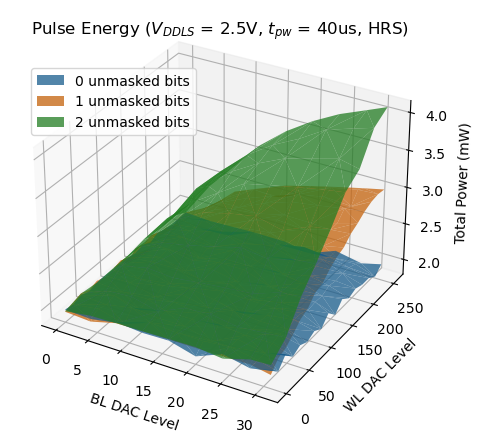

In [22]:
# 3-D plot of pulse energy vs. {VWL, VBL, number of bits unmasked}
fig = plt.figure(figsize=(5.5, 4.5))
ax = plt.axes(projection='3d')
ax.set_title(f"SET Pulse Energy ($V_{{DDLS}}$ = {vddio/10}V, $t_{{pw}}$ = 40µs, HRS)", y=1)
ax.set_xlabel("BL DAC Level")
ax.set_ylabel("WL DAC Level")
ax.set_zlabel("Total Power (mW)")
for i in range(3):
    e = edata[edata['n'] == i]
    surf = ax.plot_trisurf(e['vbl'], e['vwl'], e['totpow'] * 1000, label=f"{i} unmasked bits", alpha=0.75)
    surf._facecolors2d = surf._facecolor3d
    surf._edgecolors2d = surf._edgecolor3d
ax.legend(loc=(0.05, 0.7))
plt.tight_layout()
plt.savefig(f"figs/setenergy{vddio}.pdf")
plt.show()

### RESET Pulse Energy

In [29]:
# Load data and convert voltage/current to power
edatas = []
for i in range(3):
    vs = ["vdd", "vdd_dac", "vsa", "vddio", "vddio_dac"]
    edata = pd.read_csv(f"../data/resetenergy{vddio}_x{i}.csv", delimiter="\t", names=["time", "vwl", "vsl", "pw", "i(vdd)", "i(vdd_dac)", "i(vsa)", "i(vddio)", "i(vddio_dac)", "v(vddio)", "v(vddio_dac)"])
    edata["v(vdd)"] = edata["v(vdd_dac)"] = edata["v(vsa)"] = 0.9
    for v in vs:
      edata[f"p({v})"] = edata[f"v({v})"] * edata[f"i({v})"]
    edata["totpow"] = sum([edata[f"p({v})"] for v in vs])
    edata["n"] = i
    edatas.append(edata)
edata = pd.concat(edatas)
edata

,time,vwl,vsl,pw,i(vdd),i(vdd_dac),i(vsa),i(vddio),i(vddio_dac),v(vddio),...,v(vdd),v(vdd_dac),v(vsa),p(vdd),p(vdd_dac),p(vsa),p(vddio),p(vddio_dac),totpow,n
0,1.686688e+09,0,0,3968,0.000090,0.000092,0.000090,0.000691,2.425660e-07,2.50019,...,0.9,0.9,0.9,0.000081,0.000082,0.000081,0.001726,6.066236e-07,0.001971,0
1,1.686688e+09,0,4,3968,0.000090,0.000091,0.000090,0.000709,2.441090e-07,2.50019,...,0.9,0.9,0.9,0.000081,0.000082,0.000081,0.001773,6.104824e-07,0.002018,0
2,1.686688e+09,0,8,3968,0.000090,0.000092,0.000090,0.000687,2.421650e-07,2.50019,...,0.9,0.9,0.9,0.000081,0.000082,0.000081,0.001718,6.056208e-07,0.001962,0
3,1.686688e+09,0,12,3968,0.000090,0.000091,0.000090,0.000689,2.418190e-07,2.50019,...,0.9,0.9,0.9,0.000081,0.000082,0.000081,0.001723,6.047555e-07,0.001967,0
4,1.686688e+09,0,16,3968,0.000089,0.000091,0.000090,0.000719,2.429000e-07,2.50019,...,0.9,0.9,0.9,0.000080,0.000082,0.000081,0.001798,6.074589e-07,0.002043,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,1.686693e+09,255,16,3968,0.000090,0.000091,0.000062,0.001325,2.373420e-07,2.50009,...,0.9,0.9,0.9,0.000081,0.000082,0.000056,0.003314,5.935615e-07,0.003533,2
90,1.686693e+09,255,20,3968,0.000004,0.000076,0.000062,0.001404,2.374670e-07,2.50009,...,0.9,0.9,0.9,0.000003,0.000068,0.000056,0.003511,5.938741e-07,0.003639,2
91,1.686693e+09,255,24,3968,0.000089,0.000091,0.000062,0.001449,2.393410e-07,2.50009,...,0.9,0.9,0.9,0.000080,0.000082,0.000056,0.003623,5.985607e-07,0.003843,2
92,1.686693e+09,255,28,3968,0.000090,0.000091,0.000062,0.001531,2.385000e-07,2.50009,...,0.9,0.9,0.9,0.000081,0.000082,0.000056,0.003827,5.964575e-07,0.004046,2


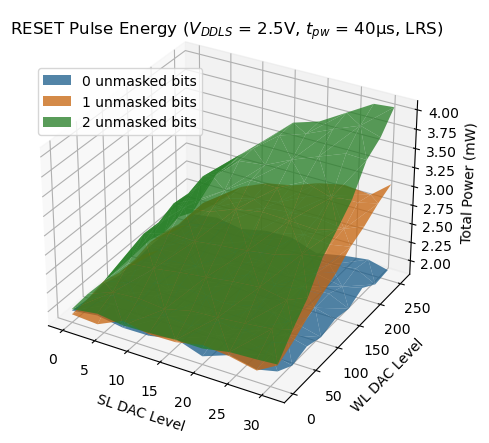

In [30]:
# 3-D plot of pulse energy vs. {VWL, VSL, number of bits unmasked}
fig = plt.figure(figsize=(5.5, 4.5))
ax = plt.axes(projection='3d')
ax.set_title(f"RESET Pulse Energy ($V_{{DDLS}}$ = {vddio/10}V, $t_{{pw}}$ = 40µs, LRS)", y=1)
ax.set_xlabel("SL DAC Level")
ax.set_ylabel("WL DAC Level")
ax.set_zlabel("Total Power (mW)")
for i in range(3):
    e = edata[edata['n'] == i]
    surf = ax.plot_trisurf(e['vsl'], e['vwl'], e['totpow'] * 1000, label=f"{i} unmasked bits", alpha=0.75)
    surf._facecolors2d = surf._facecolor3d
    surf._edgecolors2d = surf._edgecolor3d
ax.legend(loc=(0.05, 0.7))
plt.tight_layout()
plt.savefig(f"figs/resetenergy{vddio}.pdf")
plt.show()